In [2]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
/gdrive


In [3]:
ls

MyDrive/


In [4]:
 cd/gdrive/MyDrive/Document_Classification/

/gdrive/MyDrive/Document_Classification


In [5]:
ls

data.csv                       text-document-classification-clustering.ipynb
document-classification.ipynb  text-document-classification.ipynb
model_results.txt


In [6]:
import numpy as np
import pandas as pd

In [7]:
data = pd.read_csv('data.csv')
data.head()

,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0


In [8]:
data.shape

(2225, 2)

In [9]:
data.Label.value_counts(normalize=True)

1    0.229663
4    0.229213
0    0.187416
2    0.180225
3    0.173483
Name: Label, dtype: float64

In [10]:
data.isnull().sum()

Text     0
Label    0
dtype: int64

In [11]:
data.drop_duplicates(subset=['Text'], inplace=True)

In [12]:
data.shape

(2127, 2)

In [13]:
import keras
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token='UNK') # oov : out of vocabulry
tokenizer.fit_on_texts(data['Text'])

# print(tokenizer.word_index)
# print(tokenizer.index_word)
# print(tokenizer.word_counts)

word_counts = len(tokenizer.word_index) + 1
print(word_counts)

32362


# covert each sentence to ids

In [14]:
sequences = tokenizer.texts_to_sequences(data['Text'])

# padding

In [15]:
max_length = np.mean([len(seq) for seq in sequences])
print(max_length)

388.68453220498355


### padding : add zeros if the sentence have a words less than the max length
### truncation : remove words from sentence if it has a words above the max length.

In [16]:
from keras.preprocessing.sequence import pad_sequences

padded_sequences = pad_sequences(sequences, padding='post', truncating='post', maxlen=400)

In [17]:
padded_sequences.shape

(2127, 400)

In [18]:
padded_sequences

array([[ 398,    3,  109, ...,   28,  218, 1598],
       [3191, 4738,    7, ...,    2,  544,   23],
       [ 282, 3471, 2484, ..., 1152,    6, 2003],
       ...,
       [ 824, 8245, 1397, ...,    0,    0,    0],
       [ 161, 1246,  345, ...,   24,  254,  386],
       [  48,  423, 2197, ...,    0,    0,    0]], dtype=int32)

# split the data to train and test

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data['Label'],
                                                    test_size=0.2,
                                                    random_state=123,
                                                    stratify=data['Label'],
                                                    shuffle=True)

# One Hot Encoding Labels

In [20]:
from keras.utils import to_categorical

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

y_train_encoded

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

# Model Building

In [21]:
def relu(x):
    return np.maximum(0, x)
relu(-10)

0

In [22]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(input_dim=word_counts, output_dim=300, input_length=400, mask_zero=True)) # output (عدد الكلمات في طول الفيكتور)
model.add(layers.Flatten()) # # output >>  (2127, 300) # output the average vector for each sentence
model.add(layers.BatchNormalization()) # output >>  (2127, 300)
model.add(layers.Dense(128, activation='relu')) # (300, 128)
model.add(layers.Dense(256, activation='relu')) # (128, 256) >> (2127, 256)
model.add(layers.Dense(5)) # (256, 5) >> (2127, 5)
model.add(layers.Softmax())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Training Model

In [23]:
# model.fit(X_train, y_train_encoded, epochs=20, batch_size=128, validation_split=0.1)
model.fit(X_train, y_train_encoded, epochs=30, batch_size=128, validation_data=(X_test, y_test_encoded)) # using test data as validation data too.

Epoch 1/30
14/14 [==============================] - 20s 1s/step - loss: 4.9949 - acc: 0.3286 - val_loss: 1.5693 - val_acc: 0.3615
Epoch 2/30
14/14 [==============================] - 18s 1s/step - loss: 0.1509 - acc: 0.9577 - val_loss: 1.4885 - val_acc: 0.4014
Epoch 3/30
14/14 [==============================] - 18s 1s/step - loss: 0.0193 - acc: 0.9929 - val_loss: 1.4721 - val_acc: 0.4296
Epoch 4/30
14/14 [==============================] - 18s 1s/step - loss: 0.0012 - acc: 1.0000 - val_loss: 1.4613 - val_acc: 0.4178
Epoch 5/30
14/14 [==============================] - 18s 1s/step - loss: 4.6085e-04 - acc: 1.0000 - val_loss: 1.4490 - val_acc: 0.4413
Epoch 6/30
14/14 [==============================] - 17s 1s/step - loss: 2.4367e-04 - acc: 1.0000 - val_loss: 1.4373 - val_acc: 0.4671
Epoch 7/30
14/14 [==============================] - 17s 1s/step - loss: 1.5239e-04 - acc: 1.0000 - val_loss: 1.4257 - val_acc: 0.4859
Epoch 8/30
14/14 [==============================] - 17s 1s/step - loss: 2.8308

In [24]:
model.evaluate(X_test, y_test_encoded)

14/14 [==============================] - 1s 53ms/step - loss: 0.9328 - acc: 0.7089


[0.9327991604804993, 0.7089201807975769]

In [25]:
predictions = model.predict(X_test).argmax(axis=1)

14/14 [==============================] - 1s 34ms/step


In [29]:
model.save("my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
predictions

array([0, 2, 2, 2, 3, 1, 2, 1, 1, 4, 2, 3, 1, 0, 1, 4, 4, 2, 4, 1, 4, 0,
       1, 4, 4, 1, 3, 2, 3, 4, 1, 4, 1, 1, 1, 0, 3, 2, 1, 3, 4, 2, 4, 2,
       2, 3, 4, 3, 4, 2, 4, 2, 1, 3, 2, 1, 2, 3, 2, 3, 1, 1, 1, 3, 4, 3,
       3, 1, 1, 0, 1, 4, 1, 3, 2, 4, 0, 0, 3, 0, 4, 2, 1, 1, 1, 1, 0, 2,
       4, 4, 4, 0, 1, 3, 1, 1, 4, 0, 3, 0, 2, 1, 4, 4, 0, 1, 2, 4, 0, 0,
       1, 1, 1, 4, 3, 1, 2, 0, 4, 1, 4, 1, 2, 4, 1, 4, 0, 2, 2, 3, 2, 0,
       2, 1, 2, 1, 1, 3, 3, 4, 0, 2, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 4,
       3, 4, 2, 2, 1, 1, 3, 3, 2, 1, 4, 2, 0, 4, 4, 1, 4, 1, 1, 2, 4, 4,
       0, 0, 1, 1, 1, 2, 2, 4, 3, 3, 4, 3, 2, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       4, 4, 4, 1, 4, 2, 4, 4, 0, 2, 3, 4, 3, 1, 4, 2, 1, 2, 4, 4, 4, 4,
       0, 2, 1, 1, 2, 4, 3, 0, 1, 1, 3, 3, 4, 1, 1, 2, 4, 2, 3, 2, 0, 1,
       1, 1, 1, 3, 2, 1, 4, 4, 3, 0, 2, 3, 4, 1, 3, 2, 4, 1, 4, 4, 1, 4,
       0, 3, 2, 4, 1, 0, 4, 0, 3, 1, 4, 0, 3, 4, 1, 0, 0, 1, 2, 0, 4, 3,
       3, 1, 0, 1, 3, 4, 1, 3, 1, 1, 1, 1, 2, 2, 1,

In [27]:
y_test.values

array([0, 4, 2, 3, 3, 1, 2, 1, 1, 3, 3, 1, 1, 0, 1, 3, 0, 2, 4, 1, 4, 0,
       1, 4, 4, 4, 3, 0, 3, 4, 1, 4, 3, 0, 0, 0, 3, 2, 3, 3, 4, 0, 4, 2,
       2, 4, 2, 3, 4, 2, 0, 2, 3, 3, 4, 1, 4, 3, 2, 4, 1, 1, 1, 1, 4, 2,
       3, 1, 1, 4, 3, 0, 1, 3, 4, 2, 3, 4, 4, 2, 4, 2, 0, 1, 1, 1, 0, 3,
       4, 4, 4, 0, 1, 4, 4, 1, 3, 0, 1, 0, 3, 1, 4, 4, 0, 1, 2, 4, 4, 0,
       1, 1, 1, 4, 3, 1, 2, 0, 4, 3, 4, 1, 2, 4, 3, 4, 0, 4, 2, 3, 2, 0,
       4, 1, 2, 1, 1, 0, 3, 4, 0, 4, 1, 0, 0, 0, 0, 4, 2, 0, 1, 4, 2, 2,
       3, 4, 2, 0, 3, 1, 3, 3, 3, 1, 4, 2, 0, 3, 4, 1, 4, 3, 1, 2, 3, 4,
       0, 3, 1, 1, 1, 2, 2, 4, 4, 3, 4, 3, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       4, 4, 0, 0, 4, 2, 4, 3, 0, 4, 3, 4, 3, 1, 2, 3, 1, 2, 4, 4, 4, 2,
       0, 2, 1, 1, 0, 3, 3, 0, 1, 1, 4, 3, 0, 1, 1, 2, 0, 2, 3, 0, 0, 1,
       1, 1, 1, 3, 2, 1, 4, 4, 3, 2, 3, 4, 2, 1, 3, 2, 4, 1, 4, 3, 1, 4,
       0, 3, 2, 2, 1, 0, 2, 0, 4, 1, 4, 0, 3, 4, 1, 0, 0, 1, 2, 0, 4, 0,
       0, 1, 0, 1, 3, 4, 1, 3, 1, 1, 1, 1, 2, 2, 1,

              precision    recall  f1-score   support

           0       0.54      0.86      0.67        51
           1       0.95      0.82      0.88       117
           2       0.71      0.64      0.67        77
           3       0.61      0.59      0.60        76
           4       0.67      0.65      0.66       105

    accuracy                           0.71       426
   macro avg       0.70      0.71      0.70       426
weighted avg       0.73      0.71      0.71       426



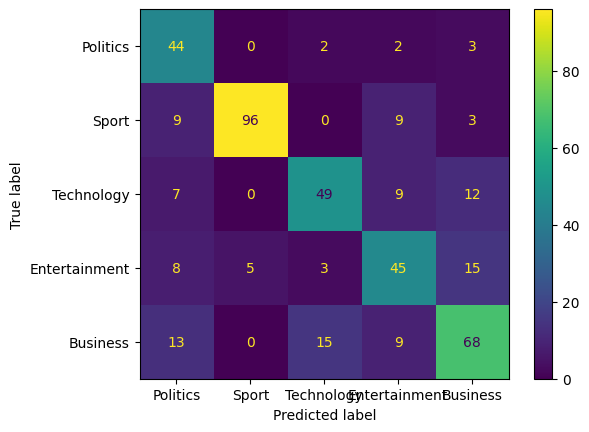

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(predictions, y_test.values))

ConfusionMatrixDisplay(confusion_matrix(predictions, y_test.values),
                             display_labels=['Politics', 'Sport', 'Technology', 'Entertainment', 'Business']).plot()